# System Performance and Latency Analysis of Local and Cloud (Google GKE) Deployments. 

##### Last update: 2022-08-23 (YYYY-MM-DD)
##### **Author: Jerome Onwunalu**

## Introduction

We present results of worker server runtimes (latencies) for different deployment options for an application. The objective of the experiments here is to quantify network latencies and benchmark the number of machines required to deliver a certain level of performance when the workers are deployed to the Google Kubernetes Engine (GKE). Additionally, the focus is not to compare the run times of the local and GKE deployment options. 


At a highlevel, a user sends a HTTP request to a server (hereafter backend server). The backend server, after some input processing (authentication, authorization, reading databases, augmenting input with extra configuration data, etc) forwards the request task to be performed by another server (hereafter worker server). The worker server performs the task and returns the results to the backend server. Subsequently the results are forwarded to the server.

The backend server application is developed using Django Python web framework. The worker server contains the bulk of the application logic and it is developed using the Common Lisp programming language. The Lisp binaries running on the worker servers (deployed locally and in GKE) are generated with the latest SBCL compiler (version 2.2.7, July 2022 release). 

### Local and GKE workers
The application is developed in such a way, that through a configuration variable, tasks can be sent to the workers running on the local machine, or worker pods in the GKE cluster. At the beginning of the experiment, the configuration is set, so the tasks are routed either to the local workers or the the GKE cluster but not both during the same experiment. 

In our first run with GKE cluster, we got "somewhat" poor latencies using a smaller instance type (described later) in **us-south1-a** zone. The us-south1-a was initially chosen because it is zone closest the development machine that launches the HTTP requests. The machine instance is a **e2-series**, general purpose instance with 2vCPU and 4GB RAM. 

After some research and I realized there is another machine instance better optimized for the type of tasks performed by the workers. Subsequently, I created another Kubernetes cluster in the **us-central1-a** and used a beefier compute-optimized machine (**c2d-standard-8**) which has 8vCPUs and 32 GB RAM. Consequently, for the Kubernetes analyses, we have two cases corresponding to two runs with smaller and larger machine instances. 

The experiment setup for the local and GKE workers are described next. 

## Objective

The objective of the performance analysis is to analyze the performance task durations when workers are deployed as follows: 

* **Case 1**: Worker server running local on the dev machine. For this case, we run an SBCL repl in a terminal.


* **Case 2**: Worker server running in docker container running locally on dev machine. For this case, we use 'docker run' command to launch the container in a terminal.


* **Case 3**: Worker server deployed as single pod on GKE cluster
    * Case 3a: Using a general purpose E2-series machine: e2-medium (2vCPU and 4GB memory)
      The E2-series machine was selected for our first deployment test in the region closest to the development machine (us-south1-a). According to the Google Cloud Platform, the E2-series machines are recommended for general day-to-day computing and but not for compute-heavy workloads.  
    * Case 3b: For our second KGE deployment test, we elected to use the compute-optimized c2d-series instance in the us-central1-a zone. The specs for the instance is c2d-standard-8 (8vCPU and 32GB memory). On the GCP site, the c2d series machines are recommended for compute-bound workloads and high-performance computing (HPC) which closely aligns to the computing type performed by the workers (fluid mechanics simulations).

  
In Cases 1 and 2, the Lisp REPL and Docker container are running on the development machine. This machine is running Linux (openSUSE version 15.3) with the follow specification: Intel(R) Core(TM) i7-7700 CPU @ 3.60GHz, 8CPU, 64GB. For the Case 2, the docker image is first built locally and then we run it locally with 'docker run ...' command. This is the same image that is pushed to the Google Container Registry for use with the GKE deployments.  

Note that only Cases 3a and 3b are production deployments. The first two cases (1 and 2) are used to benchmark the performance of the Kubernetes deployment. Additionally, Case 3 will help evaluate the overall network latencies for the deployment case. For the Kubernetes deployments, the worker pods are exposed through a NodePort-type service. Additionally, we created an Ingress resource (nginx-ingress) so as the access the cluster and service externally. We have used this format because the application will in general, host several services and we wanted to perform the test with this configuration. An alternative configuration will be to use a LoadBalancer-type service for the pods and use its IP address to access the service. However, for the experiments here, we use the option with the Ingress resource.

In all cases, the HTTP requests are issued from the development machine from another Python client program. The requests are then routed to the backend server (Python/gunicorn server) running on port 8080 on the same development machine. The requests are then routed to local workers (Cases 1 and 2) or to worker pods running on the GKE cluster (Cases 3a and 3b). For each case, we issue 1000 serial requests to the application. All requests used the same exact input parameters to remove variability in the downstream runtimes that would result from using different inputs.

### Metrics measured
The code is instrumented to measure task durations at different tiers: backend server, worker server and job (or task) performed inside the worker server. 

For each request, three task durations are computed at the different tiers. Let T1, T2, T3 represent the durations at the backend server, worker server, and job (function call). The order of the three metrics is such that T1 > T2 > T3.

T2 and T3 are concerned with the Lisp application. The summary of results presented (later) is focused on the T2 times, i.e., worker server duration. We also measure the duration ratio metrics for the backend vs worker server (T2/T1) and job vs worker server (T3/T2).

All durations are measured in seconds.

## Caveats

In the current setup, only the worker server(s) are deployed on the GKE cluster. In the future, we plan to move the whole application into the Kubernetes cluster and this is expected to reduce the overall network latencies of the application. 

We also note that all HTTP calls are serial and snychronous with only one worker server used both locally and on the GKE. We did conduct additional experiments with multiple asynchronous requests and varying number of pods on the GKE but those results will be presented later. 


## Summary of Results

Here we present analyses of the worker server runtimes only (T2 durations). The section **Statisical Analyses of Resutls** contains data frames and statistical summaries of the T1, T2, and T3 durations for different cases. The results for the worker servers are described next. 

### Worker Server Results

The median task duration for the local REPL case (Case 1) is 1.1 seconds (see Figure below). For local Docker case (Case 2), this corresponding metric is 3.7 seconds. For the GKE deployments, the median worker durations are 7.86 seconds (Case 3a) and 4.41 seconds (Case 3b) respectively. 

The GKE cluster deployment with compute-optimized node improved the overall runtime. Specifically, using a 8cpu 32GB memory instance (Case 3b) over a 2cpu 4GB memory instance (Case 3a) resulted in an almost 100% decrease in task duration.

We note also that results for Cases 1 and 2 (running on local machine) are much faster and do not have larger network effects as all system components (client, databases, backend and worker servers, etc) are on the same machine. 

Our focus is to get the task durations for deployments on the GKE to be as low as possible considering other constraints including cost. We believe we will be able to achieve further reduction of network and overall latencies by moving the entire application (backend and worker servers) into the GKE cluster.

<img src="worker_server_deployment_comparison.jpg" class="center" width="800" height="600">

## Acknowlegments

We thank Google Cloud Platform (GCP) for providing the free cloud credits used to run the experiements. The free credits enabled the author to also learn Kubernetes and deploy the workers on the GKE cluster. The GCP credit is now exhausted. The experience working with GKE on GCP was very good and it was easy to launch the clusters and to adjust the number of pod replicas. The author is also greatful to the SBCL Lisp Compiler Development Team.

## Set of the environment

In [1]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
from pathlib import Path
from seaborn import boxplot
import seaborn as sns    

In [2]:
# Set up the top directory of the application
TOPDIR='/home/onwunalu/data/ml-outputs/cloudsim/latency-analyses/v2.2.7'
FIGDIR= '{}/figures'.format(TOPDIR)
# setup the service_name
service_name = 'xz-nz'

## Define helper functions

Several helper functions for reading input files and creating plots are described in this section.

In [3]:
def get_dataframes(casename):
    RUNDIR = TOPDIR + '/' + casename
    df_analysis = pd.read_csv(RUNDIR + '/' + service_name + '/analysis.csv', index_col=0)
    df_history  = pd.read_csv(RUNDIR + '/' + service_name + '/history.csv')
    
    return df_history, df_analysis

def make_histograms_old(df):
    fig, ax = plt.subplots(figsize=(8,6))
    df['backend_server'].plot(kind='hist', ax=ax)
    fig, ax = plt.subplots(figsize=(8,6))
    df[['backend_server', 'worker_server']].plot(kind='hist')
    
def make_histograms(df,xlim=[0,20], title=None):
    fig, ax = plt.subplots(figsize=(8,6))
    ax = sns.distplot(df['backend_server'], label='backend_server')
    ax = sns.distplot(df['worker_server'], label='worker_server')
    if xlim:
        plt.xlim(xlim)
    plt.xlabel('Latency (seconds)')
    if title:
        plt.title(title)
    ax.legend()
    
def make_box_plot(df, ylim=None, savefile=None, case=None, columns=['backend_server', 'worker_server', 'job']):
    fig, ax = plt.subplots(figsize=(8,6))
    boxplot(data=df[columns])
    if ylim:
        plt.ylim(ylim)
    plt.xlabel('Tiers')
    plt.ylabel('Latency (seconds)')
    plt.title('{}Tracking latencies across different systems points'.format(case + ': ' if case else ''))
    #plt.xticks(ticks=[0,1,2],labels=['python/django/gunicorn', 'sbcl/hunchentoot', 'sbcl_task'])
    plt.xticks(ticks=[0,1,2],labels=['backend_server', 'worker_server', 'job'])
    if savefile:
        fig.savefig(savefile, dpi=300)

def make_boxplot_all_cases(df, filename, title=None): 
    fig, ax = plt.subplots(figsize=(8,6))
    boxplot(x='case',y='worker_server',data=df_all)
    plt.xlabel('Deployment options')
    plt.ylabel('Worker Server Task Durations (seconds)')
    plt.ylim([0, 10])    
    #ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    if title:
        plt.title(title)
    plt.show()
    if filename:        
        fig.savefig('{}/{}'.format(FIGDIR, filename), dpi=300)
    
        
def make_ratio_plots(df, filename, title=None):
    fig, ax = plt.subplots(figsize=(8,6))
    
    plt.plot(df[['job_over_worker_server', 'worker_over_backend']])
    plt.xlim([0, len(df)])
    plt.ylim([0, 1.0])
    plt.legend(['job/worker_server', 'worker_server/backend_server'])
    plt.xlabel('Index of run')
    plt.ylabel('Latency Ratios')
    if title:
        plt.title(title)
    else:
        plt.title('Comparison of latency ratios')
    fig.savefig('{}/{}'.format(FIGDIR, filename), dpi=300)

## Load data for different runs

For each the cases described early, we issued 1000 sequential http-requests to the workers deployed on the local repl, docker container or in GKE cluster. The results are recorded and we performed statistical analyses of the results. The resulting analysis and history files were saved. The files are loaded as follows:

In [4]:
df_repl_hist, df_repl_analysis = get_dataframes('repl-local')
df_docker_hist, df_docker_analysis = get_dataframes('docker-local')
df_kge2cpu_hist, df_kge2cpu_analysis = get_dataframes('kge-2vcpu-4gb')
df_kge8cpu_hist, df_kge8cpu_analysis = get_dataframes('kge-8vcpu-32gb')

df_docker_hist['case']  = 'docker_local'
df_repl_hist['case']    = 'repl_local'
df_kge2cpu_hist['case'] = 'gke_e2_2cpu_4gb'
df_kge8cpu_hist['case'] = 'gke_c2d_8cpu_32gb'

# Combine all dataframes
df_all = pd.concat([df_repl_hist, df_docker_hist, df_kge2cpu_hist, df_kge8cpu_hist])

## Analysis of metrics for Local REPL case

Here we provide additional details for the columsn in a data frame. 

In [10]:
# View the columns of a data frame for local run
df_repl_hist.head()

,backend_server,worker_server,job,worker_over_backend,job_over_worker_server,case
0,1.295674,1.113057,1.099144,0.859056,0.987500,repl_local
1,1.472023,1.088808,1.074722,0.739668,0.987063,repl_local
2,1.285517,1.114736,1.100701,0.867150,0.987410,repl_local
3,1.274525,1.072512,1.058448,0.841499,0.986887,repl_local
4,1.288606,1.098744,1.084529,0.852661,0.987063,repl_local


The above shows the columns of one of the data frames. The columns of the dataframe are related to the request sent from a user to backend webserver and then subsequently to worker.

The request sequence goes to the backend_server ('backend_server' column) which forwards the requests to one of the SBCL workers. The worker does some prework (preparing of input files, etc) and then
calls an external exec that performs the job. The columns **backend_server**, **worker_server**, and **job** corresponds the the duration of requests at different tiers. The columns are explained below (we ignore the index column in the explanation below):

1. **backend_server**: This column contains the latency (seconds) for the backend server. This is T1 duration.

2. **worker_server**: This column contains the latency (seconds) for the worker_server. This is  T2 duration.

3. **job**: This column contains the duration of the task (timed from within SBCL). This is T3 duration.

4. **work_over_backend**: This column contains the ratio of the latency in columns 2 and 1. This column is computed as T2/T1.

5. **job_over_worker_server**: This column contains the ratio of latency in columns 3 and 2. This column is computed as T3/T2.

The ratio columns are used to track efficiency of calls as it goes through the different tiers. The ratio of job over worker_server durations (T3/T2) is approximately 0.99. The same T3/T2 ratios are observed for the Docker and KGE cases. 

The ratio of worker_server and backend_server durations (T2/T1) shows a lot of variability mostly attributable to input processing (database read/write calls, data augmentation, etc) and network effects (see plots below).

## Statistical Anayses of Results

All durations are in seconds unit.

### Case 1: Task durations for different tiers for local REPL deployment

In [6]:
df_repl_analysis

,backend_server,worker_server,job,worker_over_backend,job_over_worker_server
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.496799,1.130001,1.115184,0.817667,0.986810
std,0.975650,0.109763,0.109731,0.113050,0.001993
min,1.170054,0.996052,0.982163,0.098698,0.948178
median,1.306526,1.108537,1.094102,0.852719,0.986929
p99,6.293321,1.497802,1.482908,0.882052,0.990479
max,15.624989,2.695540,2.681355,0.923125,0.994738


### Case 2: Summary of task durations for local Docker deployment

In [7]:
df_docker_analysis

,backend_server,worker_server,job,worker_over_backend,job_over_worker_server
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,4.184801,3.726230,3.710387,0.917621,0.995743
std,1.106905,0.151712,0.151683,0.107947,0.000376
min,3.732346,3.570308,3.555079,0.232520,0.988601
median,3.891876,3.697236,3.681459,0.951957,0.995782
p99,10.078449,4.179283,4.163861,0.960154,0.996273
max,16.145132,6.563850,6.548206,0.963426,0.997617


### Case 3a: Summary of task durations for GKE Case 3a (using e2-series machine)

In [8]:
df_kge2cpu_analysis

,backend_server,worker_server,job,worker_over_backend,job_over_worker_server
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,8.224106,7.871626,7.845914,0.957734,0.996733
std,0.257475,0.106352,0.106514,0.021244,0.000490
min,7.884965,7.596893,7.572904,0.609165,0.992479
median,8.197095,7.864191,7.838771,0.961233,0.996890
p99,8.983689,8.147073,8.122892,0.969491,0.997031
max,12.664277,8.404103,8.379235,0.971797,0.997078


### Case 3b: Summary of task durations for GKE Case 3b (using c2d-series machine)

In [9]:
df_kge8cpu_analysis

,backend_server,worker_server,job,worker_over_backend,job_over_worker_server
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,5.210937,4.434674,4.419275,0.887332,0.996525
std,1.702404,0.075544,0.076031,0.121907,0.001005
min,4.643919,4.317042,4.293396,0.157586,0.992152
median,4.774477,4.409249,4.394096,0.928249,0.996936
p99,13.388138,4.660119,4.646655,0.937752,0.997106
max,28.148664,4.752503,4.739051,0.940764,0.997169


## Comparison of the ratio of job and worker_server durations

/home/onwunalu/.pyenv/versions/cloudsim/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/onwunalu/.pyenv/versions/cloudsim/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/onwunalu/.pyenv/versions/cloudsim/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a

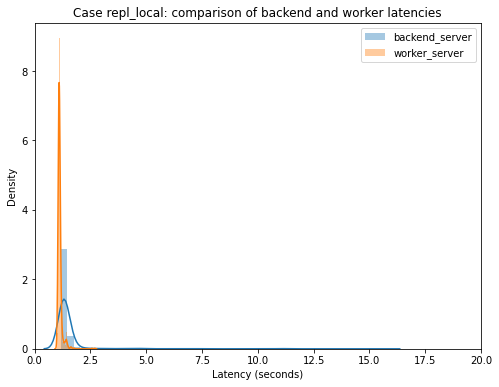

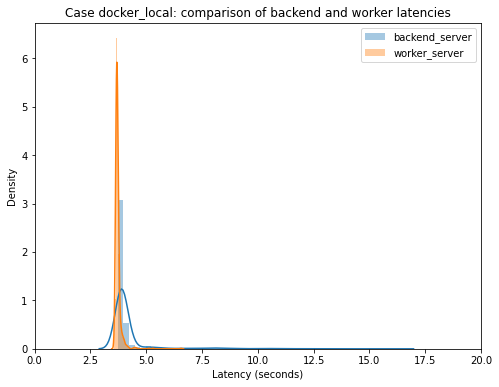

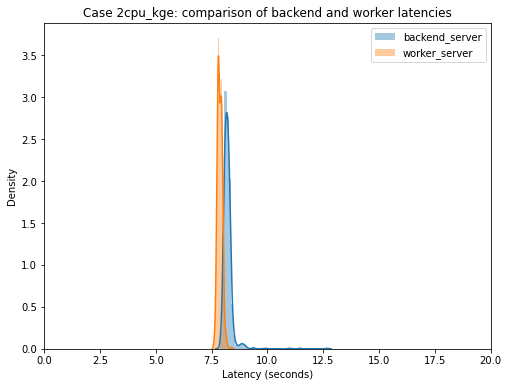

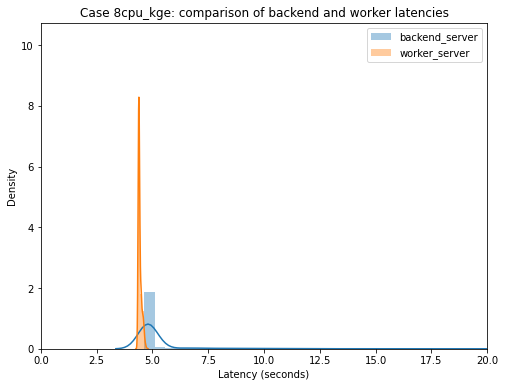

In [92]:
make_histograms(df_repl_hist, title='Case repl_local: comparison of backend and worker latencies')
make_histograms(df_docker_hist, title='Case docker_local: comparison of backend and worker latencies')
make_histograms(df_kge2cpu_hist, title='Case 2cpu_kge: comparison of backend and worker latencies')
make_histograms(df_kge8cpu_hist, title='Case 8cpu_kge: comparison of backend and worker latencies')

## Latency Ratio plots

Here we plot the latency ratio plots described in the previous section.

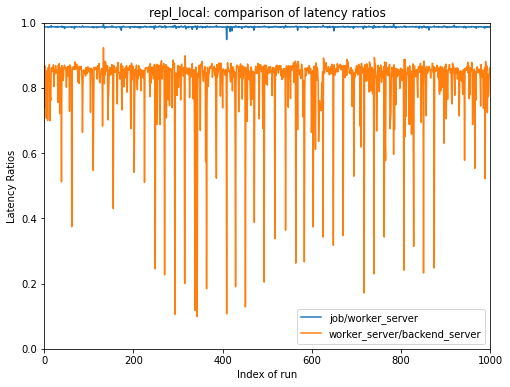

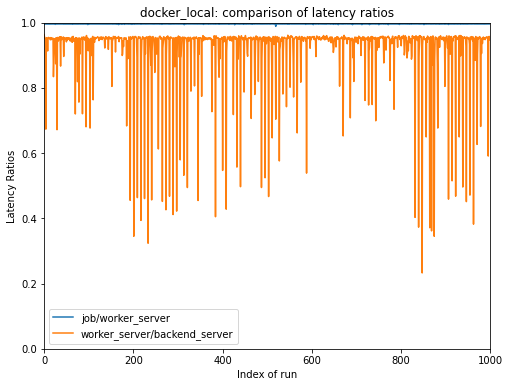

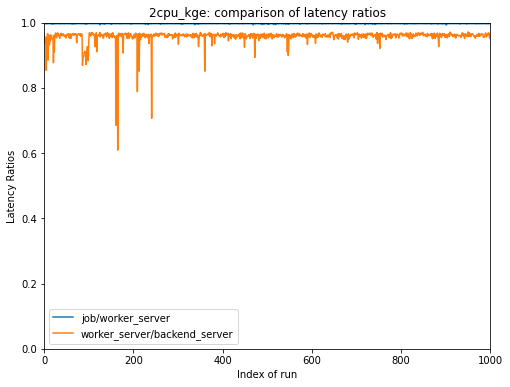

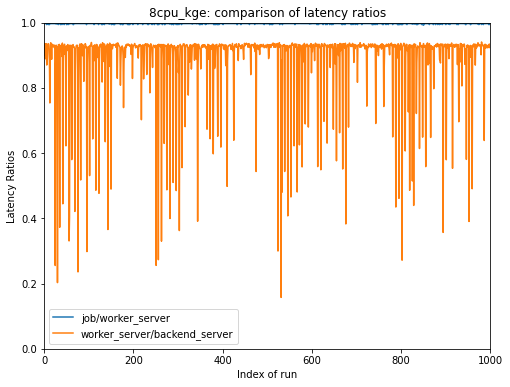

In [93]:
make_ratio_plots(df_repl_hist, 'repl_local_ratio_plots.png',title='repl_local: comparison of latency ratios')
make_ratio_plots(df_docker_hist, 'docker_local_ratio_plots.png', title='docker_local: comparison of latency ratios')
make_ratio_plots(df_kge2cpu_hist, 'docker_local_ratio_plots.png', title='2cpu_kge: comparison of latency ratios')
make_ratio_plots(df_kge8cpu_hist, 'docker_local_ratio_plots.png', title='8cpu_kge: comparison of latency ratios')

In [15]:
# Combine all dataframes
df_all = pd.concat([df_repl_hist, df_docker_hist, df_kge2cpu_hist, df_kge8cpu_hist])

In [9]:
df_all['worker_server']

0      1.113057
1      1.088808
2      1.114736
3      1.072512
4      1.098744
         ...   
995    4.414282
996    4.450002
997    4.382260
998    4.547550
999    4.384909
Name: worker_server, Length: 4000, dtype: float64

/home/onwunalu/.pyenv/versions/cloudsim/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/onwunalu/.pyenv/versions/cloudsim/lib/python3.9/site-packages/seaborn/distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/onwunalu/.pyenv/versions/cloudsim/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/onwunalu/.pyenv/versions/cloudsim/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/onwunalu/.pyenv/versions/cloudsim/lib/python3.9/site-packages/seabo

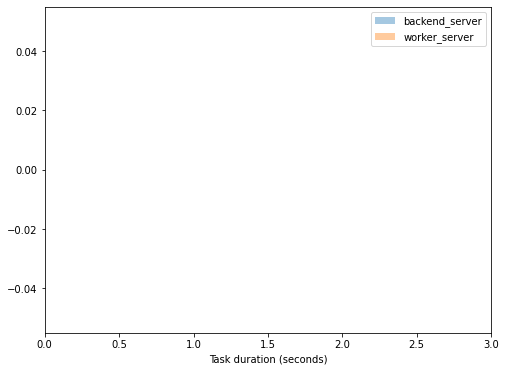

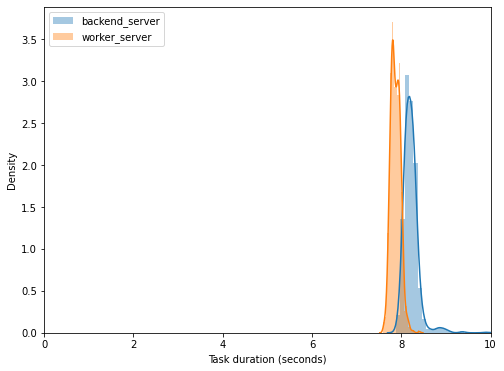

In [ ]:
make_histograms(df_all[df_all['case'] == 'repl_dev_machine'], [0, 3])
make_histograms(df_all[df_all['case'] == 'kubernetes/gke'], [0, 10])

## Box Plots

Here we show box plots of the latency at different tiers for different deployment cases.The box show show the distribution for the latencies

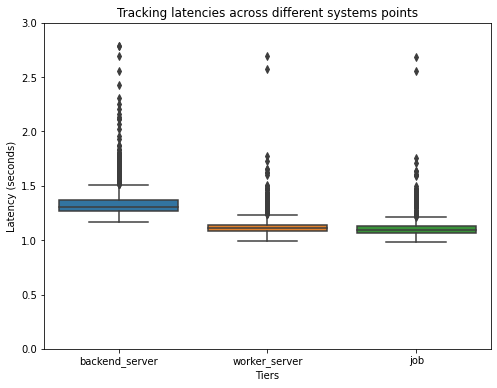

In [ ]:
make_box_plot(df_repl_hist,ylim=[0,3])

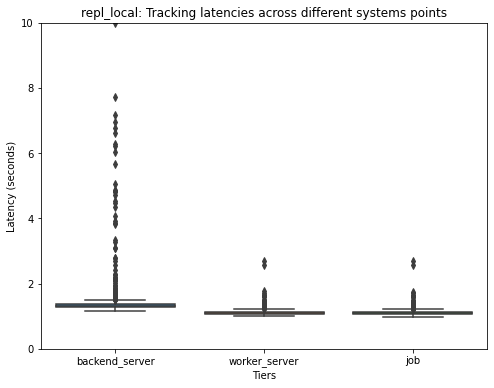

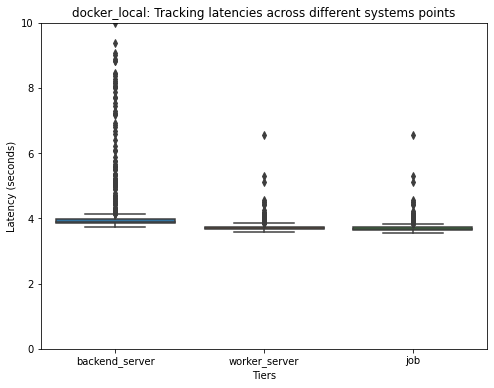

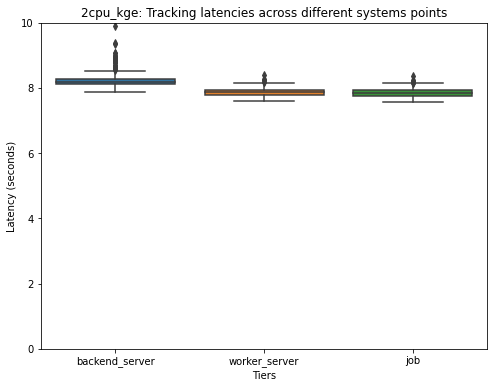

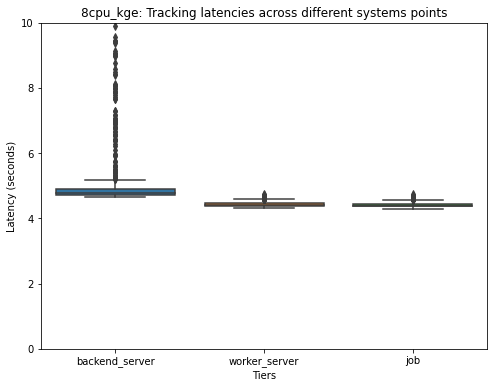

In [ ]:
# Truncate the long extreme values to say 10 sections
make_box_plot(df_repl_hist, ylim=[0, 10], case='repl_local')
make_box_plot(df_docker_hist, ylim=[0, 10], case='docker_local')
make_box_plot(df_kge2cpu_hist, ylim=[0, 10], case='2cpu_kge')
make_box_plot(df_kge8cpu_hist, ylim=[0, 10], case='8cpu_kge')

## Comparison of worker server task durations for different deployments

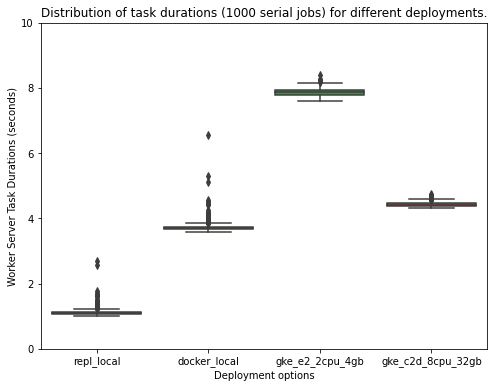

In [25]:
make_boxplot_all_cases(df_all, filename='worker_server_deployment_comparison.jpg', title='Distribution of task durations (1000 serial jobs) for different deployments.')